<a href="https://colab.research.google.com/github/1y33/Deep-Learning/blob/main/MNIST_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

device="cuda" if torch.cuda.is_available() else "cpu"

In [72]:
train_data=datasets.EMNIST(
    root="data",
    split="digits",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data=datasets.EMNIST(
    root="data",
    split="digits",
    download=True,
    transform=ToTensor()
)

In [73]:
from torch.utils.data.dataloader import DataLoader
train_dataloader=DataLoader(train_data,
                            batch_size=32,
                            shuffle=True,)
test_dataloader=DataLoader(test_data,
                           batch_size=32,
                           shuffle=True)

In [74]:
classes=train_data.classes
len(classes)

10

In [75]:
image,label=train_data[0]

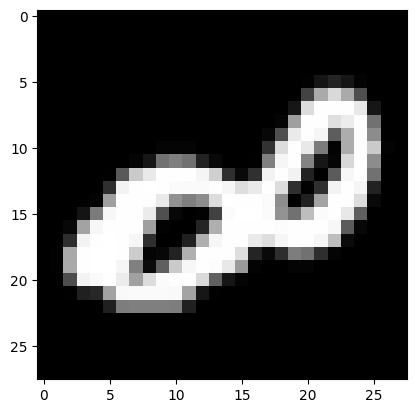

In [76]:
plt.imshow(image.squeeze(0),cmap="gray")

In [77]:
class cnn_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(2))
        self.res1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(2))
        self.res2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True))
        self.classifier = nn.Sequential(nn.Flatten(),
                          nn.Linear(256*7*7, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 256),
                          nn.ReLU(),
                          nn.Linear(256, 26)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [78]:
model = cnn_model().to(device)
model

cnn_model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequ

In [79]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.001)

In [83]:
epochs = 1

for epoch in range(epochs):
  model.train()
  running_loss=0

  for batch , (images,labels) in enumerate(train_dataloader):
    images=images.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()

  print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss / len(train_dataloader)}")

  model.eval()
  correct=0
  total=0
  with torch.inference_mode():
    for batch ,(images,labels) in enumerate(test_dataloader):
      images=images.to(device)
      labels=labels.to(device)
      outputs=model(images)
      predicted = torch.argmax(outputs, dim=1)
      total+=labels.size(0)
      correct+=(predicted==labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Accuracy on the test set: {accuracy}%")




Epoch [1/1] - Loss: 0.011531638987498203
Accuracy on the test set: 99.73166666666667%


In [87]:
from pathlib import Path

MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME="model"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)